In [37]:
from collections.abc import Sequence

from numpy.typing import NDArray
from pandas import DataFrame

import numpy as np
import pandas as pd

from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import seaborn as sns

import random

sns.set_style('whitegrid')

from cpscheduler.environment import (
    SchedulingEnv,
    SingleMachineSetup,
    WeightedTardiness,
)

from cpscheduler.heuristics import (
    PriorityDispatchingRule,
    ShortestProcessingTime,
    WeightedShortestProcessingTime,
    ModifiedDueDate,
    ApparentTardinessCost,
    TrafficPriority,
    CostOverTime,
    RandomPriority
)

from cpscheduler.rl.evaluation import confidence_interval

INSTANCE_PATH = "data/customers/wt40_50_0.5.pkl"

pdrs: dict[str, PriorityDispatchingRule] = {
    "SPT": ShortestProcessingTime(),
    "WSPT": WeightedShortestProcessingTime(),
    "MDD" : ModifiedDueDate(),
    "WMDD": ModifiedDueDate(weight_label="weight"),
    "COverT": CostOverTime(),
    "ATC": ApparentTardinessCost(5.),
    "TP" : TrafficPriority(),
}

rng = RandomPriority()

In [38]:
list_instances: list[DataFrame]
instance_info: DataFrame
customer_information: DataFrame

list_instances, instance_info, customer_information = pd.read_pickle(INSTANCE_PATH)
n_instances = len(list_instances)

optimal_cumulative = float(instance_info["optimal"].sum())

env = SchedulingEnv(
    SingleMachineSetup(),
    objective=WeightedTardiness(),
)

# Priority Dispatch Rules

In complex scheduling environments, finding optimal solutions is often computationally intractable due to the combinatorial explosion of possible job sequences and resource allocations.
Deciding whether a task has to be executed before or after another is not as straightforward as comparing each pair individually and locking their fate, as the local decision may impact future tasks in a way that is difficult to predict.
However, the cost of producing an initial order of execution by simplifying the strategy is helpful when the cost of generating a single near-optimal trajectory is much higher.
As a result, producing a high-quality (non-optimal) solution within a reasonable computational time plays a crucial role in both theoretical and practical scheduling contexts.
These methods of generating such orders are called heuristic methods, which work by leveraging problem-specific information, such as processing times, due dates, release times, or associated costs, and quick decision rules to navigate the solution space efficiently, filtering good-enough solutions and solving possible conflicts.

Among the most prominent and widely used heuristic strategies in scheduling are priority dispatch rules, which produce a total order in the task space by assigning a priority value based on readily available attributes.
The complexity of searching is relieved by relying on a dispatch rule: whenever at least one task in the environment can be executed, whether when a machine becomes idle, or when an incoming task reaches the environment, the waiting jobs are executed according to their priority, assigned by the dispatch rule.
Due to their low computational complexity and ease of implementation, dispatching rules are widely employed in practical scheduling environments, particularly in dynamic and stochastic settings where exact optimization approaches are computationally prohibitive.
As we can address a priority value for each task in the current environment, independent of when the tasks will be available or executed, we can create long-term schedule plans, highlighting their flexibility.
Furthermore, as the rules themselves are often derived from simple reasoning about the tasks' characteristics, it is easy to change when the scenario changes, and adapt the rules accordingly.
While priority dispatching rules offer significant computational advantages and operational simplicity, one major drawback lies in their dependence on specific, expert-crafted information about the scheduling environment.
The design of effective dispatching rules often requires deep domain expertise to identify which job attributes are most critical for system performance and how they should be weighted or combined into priority functions.

The objective here is to define these policies in terms of generic rules formally, so we can define possible models for generating actions in scheduling environments.
We first define these kinds of policies, developing stochastic variants and extending these ideas for learning priority dispatch rules.

> **Definition** (Priority Dispatch Rule). A priority dispatch rule (PDR) is a deterministic policy $\pi : \mathcal{S} \to \Sigma$ with a dispatch rule $\rho: \mathcal{X} \to \mathbb{R}$ such that
> $$\pi(s) = \left(\rho(\mathbf{x}_{\sigma_1}), \rho(\mathbf{x}_{\sigma_2}), \cdots, \rho(\mathbf{x}_{\sigma_n})\right)$$
>Where $\sigma_k$ is the index of the $k$-th greatest value of $\rho(s)$.

For example, the Shortest Processing Time dispatch rule is a policy that executes tasks by ascending order of processing times, \ie $\rho_\text{SPT}(\mathbf{x}_i) = -p_i$.
Some priority rules come from known properties of specific environments, enjoying optimality, or approximation results.
For example, SPT is optimal for $1\mid \mid \sum C_j$, while its weighted variant, WSPT, $\rho_\text{WSPT}(\mathbf{x}_i) = w_i/p_i$ is optimal for $1\mid \mid \sum w_jC_j$ .
Meanwhile, the Longest Processing Time LPT, the inverse of SPT, is a $4/3$-approximation for $Pm\mid \mid C_{\max}$ .
Even though they do not generalize to other classes, as Job-shop scheduling, for instance, they usually offer good enough solutions empirically.
Therefore, designing a priority dispatch rule is a heuristic approach, often tested and chosen empirically, so it maximizes some expected return.
Since this return is arbitrary, and so is its design, PDRs are good for initial schedules, especially in the context of uncertain models.

More complex dispatch rules can be designed for different rationales, depending on the known characteristics of the scheduling problem that can be exploited.
For instance, the Apparent Tardiness  is a dispatch rule for weighted tardiness problems $\bullet \mid  \mid \sum w_j T_j$.
The cost of executing a task under this rule increases exponentially as the expected completion time approaches the due date, with a lookahead parameter $\tau$ that is empirically tuned, and $\overline{p}$ is the average processing time in the instance.
$$\rho_\text{AT}(\mathbf{x}_i) = \frac{w_i}{p_i} \exp\left(\frac{- \max\{0, d_j - p_j - t\}}{\tau \,\overline{p}}\right).$$

In [4]:
random.seed(0)
n_repeat_random = 1000
random_performance = np.zeros(n_instances, dtype=np.float32)
for i, instance in enumerate(list_instances):
    env.set_instance(instance)

    for _ in range(n_repeat_random):
        obs, info = env.reset()

        action = rng(obs)
        _, reward, terminated, truncated, info = env.step(action)

        random_performance[i] += -reward

    random_performance[i] /= n_repeat_random

thresholds = np.linspace(0, 1, num=100)

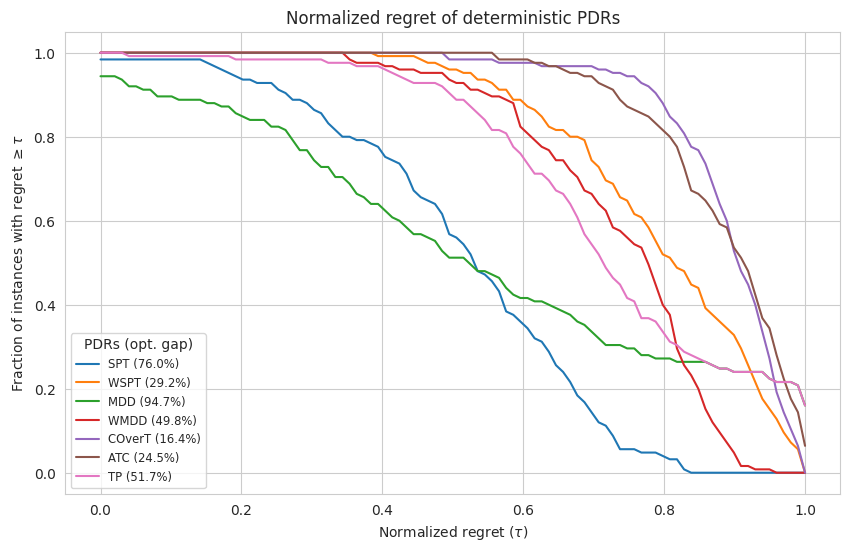

In [5]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 6))
opt_gaps: dict[str, float] = {}

for name, pdr in pdrs.items():
    performance = np.zeros(n_instances, dtype=np.float32)

    for i, instance in enumerate(list_instances):
        obs, info = env.reset(options={"instance": instance})

        action = pdr(obs)
        _, reward, terminated, truncated, info = env.step(action)

        performance[i] = - reward

    metrics = (random_performance - performance) / (random_performance - instance_info["optimal"].to_numpy())
    metrics = np.sort(metrics)
    ccdf = 1- np.sum(metrics < thresholds[:, None], axis=1) / n_instances

    opt_gaps[name] = np.sum(performance).item() / optimal_cumulative - 1

    ax.plot(thresholds, ccdf, label=f"{name} ({opt_gaps[name]:.1%})")

ax.set_xlabel(r"Normalized regret ($\tau$)")
ax.set_ylabel(r"Fraction of instances with regret $\geq \tau$")

ax.set_title("Normalized regret of deterministic PDRs")
ax.legend(title="PDRs (opt. gap)", loc='lower left', fontsize='small')

plt.savefig("notebooks/figures/pdr_performance.pdf", dpi=300, bbox_inches='tight')
plt.show()

If static dispatch rules are common practice in real scheduling due to their ease of implementation, high flexibility, and interpretability, it's natural to question whether they can be used for uncertain environments.
How could they predict orders when the parameters they rely on are unknown, or uncertain, or how could they provide stochastic results instead of deterministic rankings in order to achieve better results under uncertainty?
And how could we learn how to rank tasks based on PDRs, so our learned priorities enjoy the same attributes that make these heuristics often used?

We propose to use simple neural networks that are very similar to usual PDRs, so learning is easier when expert demonstrations are not plentiful, or when uncertainty is high enough, so the combination of a complex stochastic ranking policy with uncertainty degrades the performance deeply.

To achieve this, we need to define a method for sampling from PDRs, making them stochastic policies rather than deterministic.
This step not only guarantees semi-greedy solutions, which are potentially better than the original deterministic rankings, as other approaches suggest, as GRASP , for instance, but it also allows for policy gradient methods to be used in neural priority rules.

## Stochastic Priority Dispatch rules

Given a PDR defined by a specific rule $\rho : \mathcal{X} \to \mathbb{R}$, where $\mathcal{X}$ is the feature-space of tasks in our environment, we want to extend this dispatch rule to generate random sequences such that the probability of selecting $x_i$ at any time is
$$\mathbb{P}(x_i\text{ selected}) \propto \exp(\rho(x_i))$$

Therefore, we can then interpret each priority value as the likelihood of being chosen.
Furthermore, we can assume the odds of a given task to be chosen is independent on the pool of tasks, *i.e.*, for every task, the probability of choosing a task is always proportional to its probability of being chosen among any subset of task.

$$\mathbb{P}(x_i\text{ selected over } A) = \mathbb{P}(x_i\text{ selected over } B) \cdot \sum_{x \in B} \mathbb{P}(x\text{ selected over } B) \quad \forall x_i \in A$$

This is a simplistic model where we do not need to update our beliefs every time a task is chosen, opposed to a recurrent model, or a dynamic rule.
The equation above is called Luce's choice axiom, and appears in many models that approximate rational decision process due to its ease in ranking, providing a good proxy to more general models that require a full description of the generative process.
As it is simple to model and to do inference, it well suits the static dispatch rule perspective, generating sequences that are
- Simple to sample from
- Highly interpretable
- Easy to make assumption

The model we have chosen is the **Plackett-Luce** model, that ranks the items in a pool by selecting them, one by one, without replacement by the following rule

$$\mathbb{P}(x_i\text{ selected over } X) = \frac{\exp(\rho(x_i))}{\sum_{x \in X} \exp(\rho(x))}$$


One problem that may emerge from this, is that $\rho$ is possibly unbounded, and its value is just meaningful whe comparing tasks by value, the distance between them is not directly interpretable inside a same rule, or compared between rules.
For example, let $\rho_1, \rho_2$ be two distinct priority rules, we could sample from them directly, but the distribution $\rho_1$ will have different characteristics from $\rho_2$, which only depends on the tasks.
This means that for two different instances, $\rho_1$ might have arbitrary variance from the task's data, where $\rho_2$'s distribution is too sensible, generating almost random noise every sample.

To illustrate this behavior, we have produced a same PDR, but with different scales: The first has a expected gap between priority values in the order of 10, until the last, which is scaled by 0.01, producing priority values that are very close.
This can happen depending on the data provided from the tasks, which is not described and whose distribution is not assumed, therefore, a same environment where the weights happen to be scaled by 100, produces a much more deterministic stochastic policy when compared to the original environment.
That behavior is unintended, because who is using the PDR is responsible checking the distribution on their data and also have to understand how the PDR use the data to provide the priority values, and how these assumptions change the output distribution.
Moreover, the priority values are very different when we try to compare different PDR, their probabilities, entropy, variance, changes arbitrarely in a way that we cannot directly measure their impact on data due to an increasing uncertainty coming from the black-box PDR.

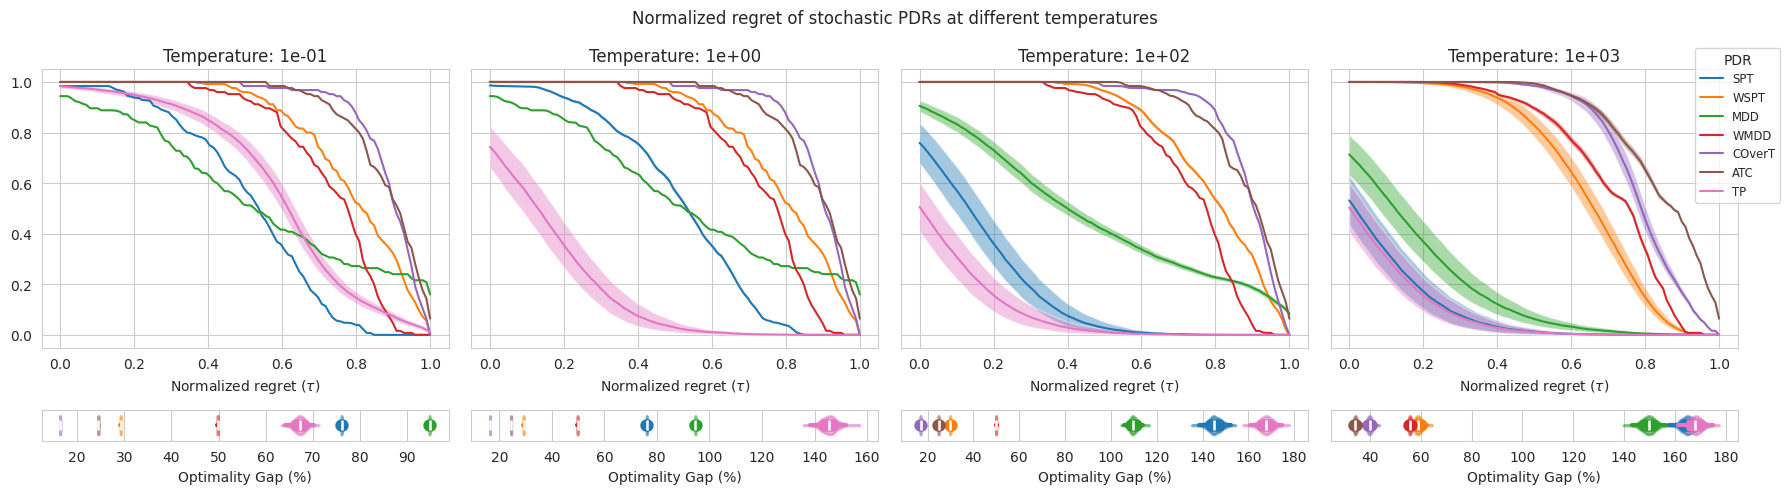

In [39]:
temps     = [0.1, 1.0, 100.0, 1000.0]
n_repeats = 100

n_bootstrap = 1000

axs: Sequence[Sequence[Axes]]
fig, axs = plt.subplots(
    nrows=2,
    ncols=len(temps),
    figsize=(18, 5),
    # sharex='col',
    sharey='row',
    gridspec_kw={'height_ratios': [9, 1]}
)

fig.subplots_adjust(wspace=0.1)
fig.suptitle("Normalized regret of stochastic PDRs at different temperatures")

axs_ccdf = axs[0]
axs_violin = axs[1]

np_rng = np.random.default_rng(0)
for ax_ccdf, ax_violin, temp in zip(axs_ccdf, axs_violin, temps):
    ax_ccdf.set_title(f"Temperature: {temp:.0e}")
    ax_ccdf.set_xlabel(r"Normalized regret ($\tau$)")

    for color_idx, (name, pdr) in enumerate(pdrs.items()):
        performance = np.zeros((n_instances, n_repeats), dtype=np.float32)

        for i, instance in enumerate(list_instances):
            env.set_instance(instance)

            for j in range(n_repeats):
                obs, info = env.reset()

                action = pdr.sample(obs, temp=temp, seed=j)
                _, reward, terminated, truncated, info = env.step(action)

                performance[i, j] = -reward

        metrics = (random_performance[:, None] - performance) / (random_performance - instance_info["optimal"].to_numpy())[:, None]

        # stochastic_opt_gaps[name] = np.sum(performance).item() / n_repeats / optimal_cumulative - 1

        mean_ccdf, lower, upper = confidence_interval(
            metrics,
            thresholds,
            n_bootstrap=n_bootstrap,
            confidence=0.95
        )
        ax_ccdf.plot(thresholds, np.mean(mean_ccdf, axis=0), label=f"{name}")
        ax_ccdf.fill_between(
            thresholds,
            np.mean(lower, axis=0),
            np.mean(upper, axis=0),
            alpha=0.4
        )

        bootstrap_choices = np_rng.integers(
            low=0,
            high=n_repeats,
            size=(n_instances, n_bootstrap)
        )
        bootstrap_performance = np.take_along_axis(performance, bootstrap_choices, axis=1)
        bootstrap_gaps = (np.sum(bootstrap_performance, axis=0) / optimal_cumulative - 1) * 100

        color = sns.color_palette()[color_idx]

        sns.violinplot(
            x=bootstrap_gaps,
            ax=ax_violin,
            linewidth=2,
            color=color,
            edgecolor=color,
            alpha=0.6,
            width=0.6
        )

        ax_violin.set_xlabel("Optimality Gap (%)")


axs_ccdf[-1].legend(
    loc='lower center',
    bbox_to_anchor=(1, 0.5),
    title="PDR",
    fontsize='small',
    # title_fontsize=12
)

plt.tight_layout()
plt.savefig("notebooks/figures/stochastic_pdr_performance.pdf", dpi=300)
plt.show()


This shows that the naive approach is not ideal for priority dispatch rules, and this problem also happens during learning, as the effect of temperature on arbitrary priority values varies a lot.
We focus on studying a uniform bound for the Plackett-Luce model regarding the scores, which has a simple enough measure to guarantee sufficient conditions for uniformity.

> **Definition** (Uniform $p^*$-first-choice bound). Let $\Omega$ be a choice set of items, each one with score $p_i > 0$, $\forall i \in \Omega$, and $\mathbb{P}$ a probability measure. We say that $\mathbb{P}$ enjoys an Uniform $p^*$-first-choice bound if there exists $p^* \in (0, 1]$ such that, for every $S \subseteq \Omega$,
>$$\mathbb{P}(\arg\max_{i \in S} p_i \mid S) \geq p^*$$

This guarantees that the ranking distribution selects the higher priority value with probability at least $p^*$, which is useful when comparing different distributions.
As the policy that always takes the maximum priority is a greedy deterministic PDR, tweaking a stochastic variant to satisfy some desired first-choice probability is a more insightful statistic than controlling temperature.

> **Lemma** (Uniform $p^*$-first-choice bound for PL models). Let $\Omega$ be a choice set of items, each one with score $p_i > 0$, $\forall i \in \Omega$, and $\mathbb{P}$ a Plackett-Luce model. Without loss of generality, re-index the scores such that $p_1 \geq p_2 \geq \dots \geq p_n$, then there exists a uniform $p^*$ bound equal to
> $$p^* = \inf_{k} \frac{p_k}{\sum_{i\geq k} p_i}$$

Therefore, given the scores, we can compute $p^*$ in a reasonable time based on the decreasing order of probabilities $p_k$.
We will use this result to obtain an approximation for turning an arbitrary PL model into another with a uniform bound close to our target $p^*$.
This is done by analyzing the conditions on $p_k$ that guarantee a $p^*$ uniform bound for any $p^* \in (0, 1]$.
The following theorem will help this goal by defining necessary conditions over the probability values for a $p^*$ bound to hold.
Based on this result, we propose an approximation that gives a stronger sufficient condition, which is not valid for any arbitrary probability vector, but is useful empirically.

> **Theorem** (Necessary condition for uniform $p^*$-bound). Let $\mathbb{P}$ be a Plackett-Luce model over a set $X$ with decreasing order of priority values $p_k > 0$, $\forall k \in \Omega$. $\mathbb{P}$ has $p^*$-first-choice bound only if for every $i, j \in \Omega$, such that $i < j$,
> $$p_i \geq \frac{p^*}{(1- p^*)^{j-i}} \, p_j$$

This theorem shows us that, for a $p^*$ bound to be valid, the probabilities must decay faster than exponentially by their rank.
However, we can obtain an interpretation of this result as a linear constraint in the log probability space, where,
$$\ell_1 \geq (k-1) \log\left(\frac{p^*}{(1-p^*)}\right) + \ell_k$$
As they require the logits that satisfy linear constraints, the case where the equality is assumed may lead to interesting results.
Supposes that the logits $\ell_1 \geq \ell_2 \geq \dots \geq \ell_n$ follow a linear relationship with respect to their ranks, \ie $\ell_k = C - \lambda (k-1)$, for some $C \in \mathbb{R}, \lambda > 0$; this distribution is $p^*$ bounded with a known relationship between $\lambda$ and $p^*$.

> **Lemma** (Uniform $p^*$-first-choice bound for PL models). Let $\Omega$ be a choice set of items, each one with score $p_i > 0$, $\forall i \in \Omega$, and $\mathbb{P}$ a Plackett-Luce model. Without loss of generality, re-index the scores such that $p_1 \geq p_2 \geq \dots \geq p_n$, then there exists a uniform $p^*$ bound equal to
> $$p^* = \inf_{k} \frac{p_k}{\sum_{i\geq k} p_i}$$


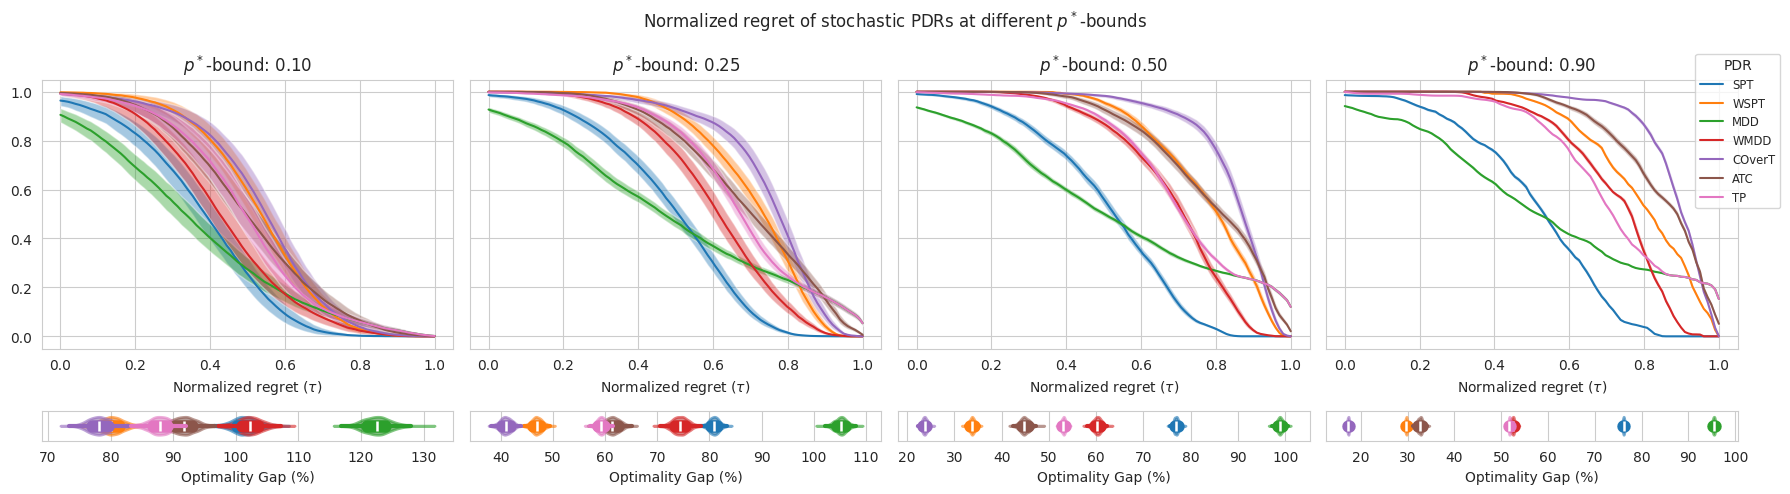

In [7]:
p_stars = [0.1, 0.25, 0.5, 0.9]
n_repeats = 100

n_bootstrap = 1000

axs: Sequence[Sequence[Axes]]
fig, axs = plt.subplots(
    nrows=2,
    ncols=len(temps),
    figsize=(18, 5),
    # sharex='col',
    sharey='row',
    gridspec_kw={'height_ratios': [9, 1]}
)

fig.subplots_adjust(wspace=0.1)
fig.suptitle("Normalized regret of stochastic PDRs at different $p^*$-bounds")

axs_ccdf = axs[0]
axs_violin = axs[1]

np_rng = np.random.default_rng(0)
for ax_ccdf, ax_violin, p_star in zip(axs_ccdf, axs_violin, p_stars):
    ax_ccdf.set_title(f"$p^*$-bound: {p_star:.2f}")
    ax_ccdf.set_xlabel(r"Normalized regret ($\tau$)")

    for color_idx, (name, pdr) in enumerate(pdrs.items()):
        performance = np.zeros((n_instances, n_repeats), dtype=np.float32)

        for i, instance in enumerate(list_instances):
            env.set_instance(instance)

            for j in range(n_repeats):
                obs, info = env.reset()

                action = pdr.sample(obs, target_prob=p_star, n_iter=10, seed=j)
                _, reward, terminated, truncated, info = env.step(action)

                performance[i, j] = -reward

        metrics = (random_performance[:, None] - performance) / (random_performance - instance_info["optimal"].to_numpy())[:, None]

        # stochastic_opt_gaps[name] = np.sum(performance).item() / n_repeats / optimal_cumulative - 1

        mean_ccdf, lower, upper = confidence_interval(
            metrics,
            thresholds,
            n_bootstrap=n_bootstrap,
            confidence=0.95
        )
        ax_ccdf.plot(thresholds, np.mean(mean_ccdf, axis=0), label=f"{name}")
        ax_ccdf.fill_between(
            thresholds,
            np.mean(lower, axis=0),
            np.mean(upper, axis=0),
            alpha=0.4
        )

        bootstrap_choices = np_rng.integers(
            low=0,
            high=n_repeats,
            size=(n_instances, n_bootstrap)
        )
        bootstrap_performance = np.take_along_axis(performance, bootstrap_choices, axis=1)
        bootstrap_gaps = (np.sum(bootstrap_performance, axis=0) / optimal_cumulative - 1) * 100

        color = sns.color_palette()[color_idx]

        sns.violinplot(
            x=bootstrap_gaps,
            ax=ax_violin,
            linewidth=2,
            color=color,
            edgecolor=color,
            alpha=0.6,
            width=0.6
        )

        ax_violin.set_xlabel("Optimality Gap (%)")


axs_ccdf[-1].legend(
    loc='lower center',
    bbox_to_anchor=(1, 0.5),
    title="PDR",
    fontsize='small',
    # title_fontsize=12
)

plt.tight_layout()
plt.savefig("notebooks/figures/stochastic_pdr_performance_pstar.pdf", dpi=300)
plt.show()


In [ ]:
del pdrs["SPT"]

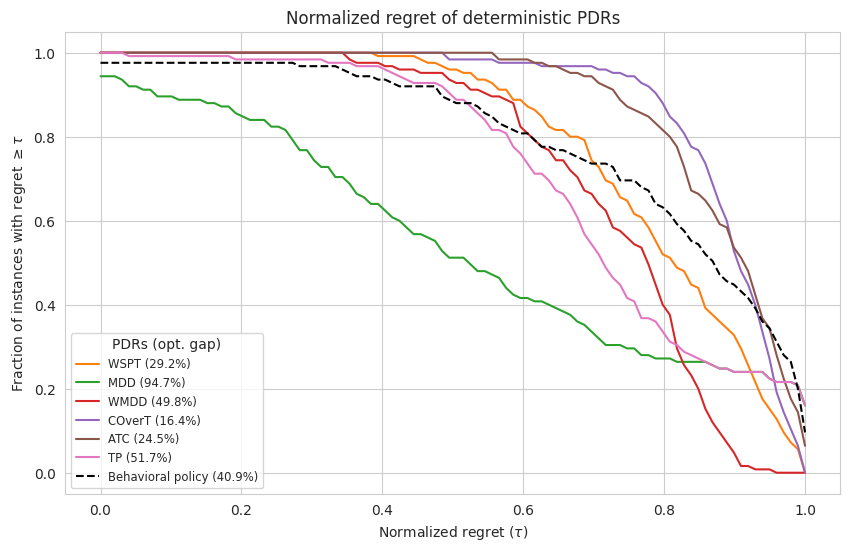

In [15]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 6))
for color_idx, (name, pdr) in enumerate(pdrs.items(), start=1):
    performance = np.zeros(n_instances, dtype=np.float32)

    for i, instance in enumerate(list_instances):
        obs, info = env.reset(options={"instance": instance})

        action = pdr(obs)
        _, reward, terminated, truncated, info = env.step(action)

        performance[i] = - reward

    metrics = (random_performance - performance) / (random_performance - instance_info["optimal"].to_numpy())
    metrics = np.sort(metrics)
    ccdf = 1- np.sum(metrics < thresholds[:, None], axis=1) / n_instances

    opt_gap = np.sum(performance).item() / optimal_cumulative - 1

    ax.plot(thresholds, ccdf, label=f"{name} ({opt_gap:.1%})", color=sns.color_palette()[color_idx])

behavior_performance = instance_info["behavior"].to_numpy()
metrics = (random_performance - behavior_performance) / (random_performance - instance_info["optimal"].to_numpy())
metrics = np.sort(metrics)
ccdf = 1- np.sum(metrics < thresholds[:, None], axis=1) / n_instances

opt_gap = np.sum(behavior_performance).item() / optimal_cumulative - 1
ax.plot(thresholds, ccdf, label=f"Behavioral policy ({opt_gap:.1%})", linestyle='--', color='black')

ax.set_xlabel(r"Normalized regret ($\tau$)")
ax.set_ylabel(r"Fraction of instances with regret $\geq \tau$")

ax.set_title("Normalized regret of deterministic PDRs and the Behavior policy")
ax.legend(title="PDRs (opt. gap)", loc='lower left', fontsize='small')

plt.savefig("notebooks/figures/behavior_performance.pdf", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_716008/126661724.py:16: RuntimeWarning: divide by zero encountered in divide
  metrics = (behavior_performance[:, None] - performance) / (behavior_performance - instance_info["optimal"].to_numpy())[:, None]
/tmp/ipykernel_716008/126661724.py:16: RuntimeWarning: invalid value encountered in divide
  metrics = (behavior_performance[:, None] - performance) / (behavior_performance - instance_info["optimal"].to_numpy())[:, None]


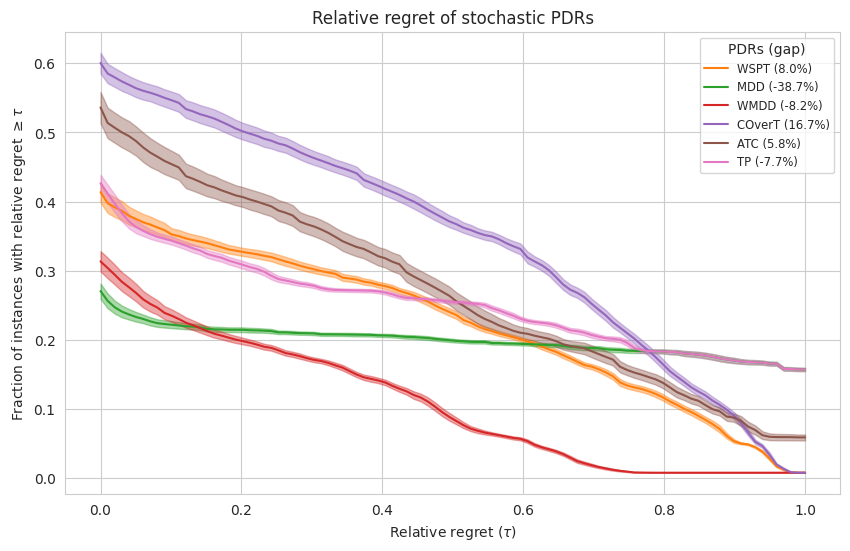

In [36]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 6))
for color_idx, (name, pdr) in enumerate(pdrs.items(), start=1):
    performance = np.zeros((n_instances, n_repeats), dtype=np.float32)

    for i, instance in enumerate(list_instances):
        env.set_instance(instance)
        for j in range(n_repeats):
            obs, info = env.reset()

            action = pdr.sample(obs, target_prob=0.9, n_iter=10, seed=j)
            _, reward, terminated, truncated, info = env.step(action)

            performance[i, j] = - reward

    # Ignore division by zero
    metrics = (behavior_performance[:, None] - performance) / (behavior_performance - instance_info["optimal"].to_numpy())[:, None]
    mean_ccdf, lower, upper = confidence_interval(
        metrics,
        thresholds,
        n_bootstrap=1000,
        confidence=0.95
    )

    beh_gap = 1 - np.sum(performance).item() / n_repeats / sum(behavior_performance)

    color = sns.color_palette()[color_idx]
    ax.plot(thresholds, np.mean(mean_ccdf, axis=0), label=f"{name} ({beh_gap:.1%})", color=color)
    ax.fill_between(
        thresholds,
        np.mean(lower, axis=0),
        np.mean(upper, axis=0),
        alpha=0.4,
        color=color
    )

ax.set_xlabel(r"Relative regret ($\tau$)")
ax.set_ylabel(r"Fraction of instances with relative regret $\geq \tau$")

ax.set_title("Relative regret of stochastic PDRs")
ax.legend(title="PDRs (gap)", fontsize='small')

plt.savefig("notebooks/figures/pdr_perfs_oracle.pdf", dpi=300, bbox_inches='tight')
plt.show()